# U.S. Presidential Election - Michigan Analysis
## Libraries

In [1]:
import warnings
warnings.simplefilter('ignore')

import requests
import lxml.html as lh

import sys

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

import networkx as nx
import plotly.graph_objects as go

sys.path.append('..')
from lmapper.filter import Projection
from lmapper.filter import Filter

from lmapper.cutoff import FirstGap

from utils import get_node_size, get_mean_node, get_mapper
from filters import SvdFilter, LpFilter
from plotting import mapper_nx_plot, mapper_plotly_plot

../lmapper/cpp/filterutils


The Python implementation of the eccentricity is used instead, but it will be slower.
The scipy.distance.cdist implementation is used instead.


In [2]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",
                                                           ["blue", "violet", "red"])
cmap_inv = matplotlib.colors.LinearSegmentedColormap.from_list("",
                                                               ["red", "violet", "blue"])

## Data

In [3]:
df = pd.read_pickle(os.path.join('data',
                                 'usa_election_full_dataset.pickle'))

num_cols = ['Personal income (thousands of dollars)',
            'Net earnings by place of residence',
            'Personal current transfer receipts',
            'Income maintenance benefits 1/',
            'Unemployment insurance compensation',
            'Retirement and other',
            'Dividends, interest, and rent 2/',
            'Population (persons) 3/',
            'Per capita personal income 4/',
            'Per capita net earnings 4/',
            'Per capita personal current transfer receipts 4/',
            'Per capita income maintenance benefits 4/',
            'Per capita unemployment insurance compensation 4/',
            'Per capita retirement and other 4/',
            'Per capita dividends, interest, and rent 4/',
            'Earnings by place of work',
            'Wages and salaries',
            'Supplements to wages and salaries',
            'Employer contributions for employee pension and insurance funds 5/',
            'Employer contributions for government social insurance',
            "Proprietors' income",
            "Farm proprietors' income",
            "Nonfarm proprietors' income",
            'Total employment (number of jobs)',
            'Wage and salary employment',
            'Proprietors employment',
            'Farm proprietors employment 6/',
            'Nonfarm proprietors employment',
            'Average earnings per job (dollars)',
            'Average wages and salaries',
            "Average nonfarm proprietors' income"]

info_cols = ['year', 'state', 'county', 'fips', 'pres']

elec_cols = ['republican', 'democrat', 'total_votes',
             'winner']

df = df[info_cols + elec_cols + num_cols]
df = df[df['state'] == 'Michigan'].reset_index(drop=True)
df.head()

year     state  county   fips  pres  republican  democrat  total_votes  \
0  2000  Michigan  Alcona  26001     1      3152.0    2696.0       5997.0   
1  2004  Michigan  Alcona  26001     1      3592.0    2871.0       6531.0   
2  2008  Michigan  Alcona  26001     0      3404.0    2896.0       6420.0   
3  2012  Michigan  Alcona  26001     0      3571.0    2472.0       6104.0   
4  2016  Michigan  Alcona  26001     1      4201.0    1732.0       6198.0   

   winner  Personal income (thousands of dollars)  ...  \
0       1                                250088.0  ...   
1       1                                262275.0  ...   
2       1                                297651.0  ...   
3       1                                325920.0  ...   
4       1                                362321.0  ...   

   Farm proprietors' income  Nonfarm proprietors' income  \
0                      45.0                      25120.0   
1                    1121.0                      16207.0   
2                     504.0                      11557.0   
3                      -7.0                      18008.0   
4                   -2513.0                      14930.0   

   Total employment (number of jobs)  Wage and salary employment  \
0                             3873.0                      2127.0   
1                             3400.0                      2054.0   
2                             3171.0                      1863.0   
3                             3035.0                      1729.0   
4                             3202.0                      1925.0   

   Proprietors employment  Farm proprietors employment 6/  \
0                  1746.0                           247.0   
1                  1346.0                           237.0   
2                  1308.0                           239.0   
3                  1306.0                           206.0   
4                  1277.0                           196.0   

   Nonfarm proprietors employment  Average earnings per job (dollars)  \
0                          1499.0                             21450.0   
1                          1109.0                             24400.0   
2                          1069.0                             25522.0   
3                          1100.0                             29051.0   
4                          1081.0                             30060.0   

   Average wages and salaries  Average nonfarm proprietors' income  
0                     21091.0                              16758.0  
1                     24333.0                              14614.0  
2                     27958.0                              10811.0  
3                     31147.0                              16371.0  
4                     33336.0                              13811.0  

[5 rows x 40 columns]

In [4]:
df[num_cols] = (df[num_cols] + abs(df[num_cols].min().min()) + 1).apply(np.log)
df.describe()

year        pres     republican       democrat    total_votes  \
count   415.000000  415.000000     415.000000     415.000000     415.000000   
mean   2008.000000    0.600000   25808.007229   29772.501205   56877.045783   
std       5.663682    0.490489   47625.593965   77190.778863  123709.134863   
min    2000.000000    0.000000     740.000000     527.000000    1343.000000   
25%    2004.000000    0.000000    5708.500000    4337.000000   10768.000000   
50%    2008.000000    1.000000    9314.000000    7212.000000   17168.000000   
75%    2012.000000    1.000000   24857.000000   20744.000000   46601.500000   
max    2016.000000    1.000000  316633.000000  660085.000000  890326.000000   

           winner  Personal income (thousands of dollars)  \
count  415.000000                              415.000000   
mean     0.727711                               14.285715   
std      0.445675                                1.241579   
min      0.000000                               11.961182   
25%      0.000000                               13.442568   
50%      1.000000                               14.039236   
75%      1.000000                               15.004435   
max      1.000000                               18.240534   

       Net earnings by place of residence  Personal current transfer receipts  \
count                          415.000000                          415.000000   
mean                            13.815101                           13.081346   
std                              1.265628                            0.911613   
min                             11.800725                           11.673487   
25%                             12.870383                           12.451522   
50%                             13.524526                           12.888993   
75%                             14.620103                           13.491388   
max                             17.849914                           16.797540   

       Income maintenance benefits 1/  ...  Farm proprietors' income  \
count                      415.000000  ...                415.000000   
mean                        11.931883  ...                 11.605080   
std                          0.478860  ...                  0.098623   
min                         11.573738  ...                 11.256238   
25%                         11.669279  ...                 11.566732   
50%                         11.764866  ...                 11.574933   
75%                         11.963750  ...                 11.623151   
max                         14.905335  ...                 12.242800   

       Nonfarm proprietors' income  Total employment (number of jobs)  \
count                   415.000000                         415.000000   
mean                     12.306392                          11.892814   
std                       0.803605                           0.450906   
min                       8.782476                          11.574961   
25%                      11.827971                          11.647832   
50%                      12.027711                          11.725558   
75%                      12.467533                          11.939741   
max                      15.979268                          13.947117   

       Wage and salary employment  Proprietors employment  \
count                  415.000000              415.000000   
mean                    11.842511               11.664190   
std                      0.415278                0.162837   
min                     11.572693               11.570345   
25%                     11.625379               11.592559   
50%                     11.688105               11.611150   
75%                     11.865306               11.658501   
max                     13.859222               12.659375   

       Farm proprietors employment 6/  Nonfarm proprietors employment  \
count                      415.000000                      415.000000   
mean               

In [5]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

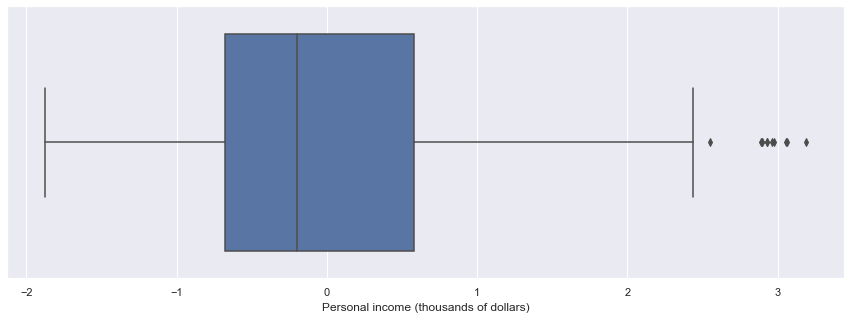

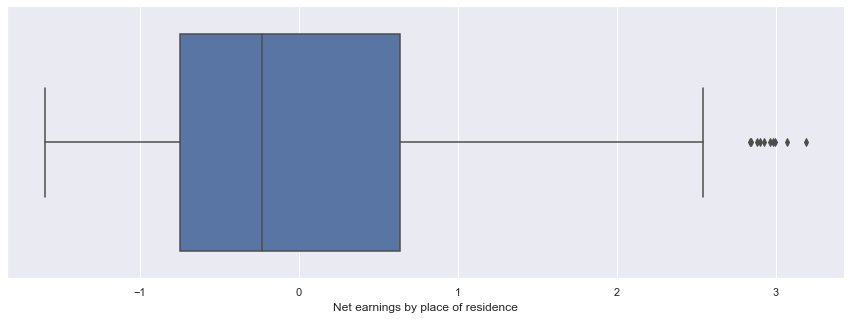

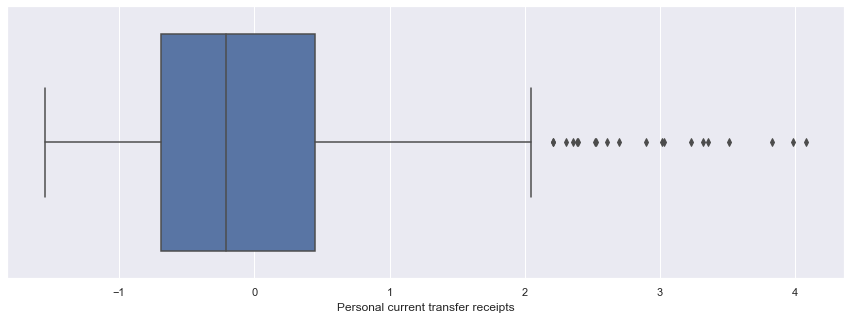

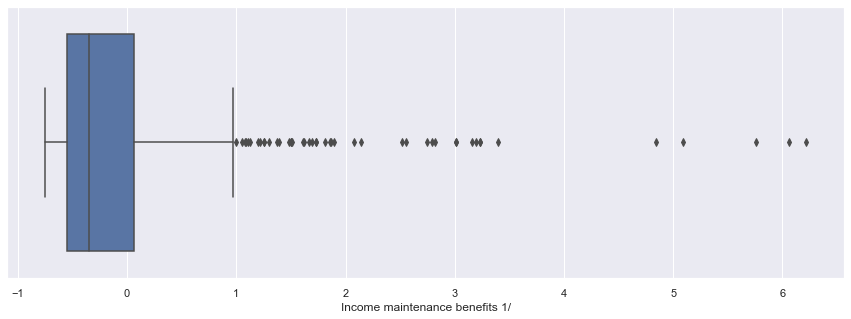

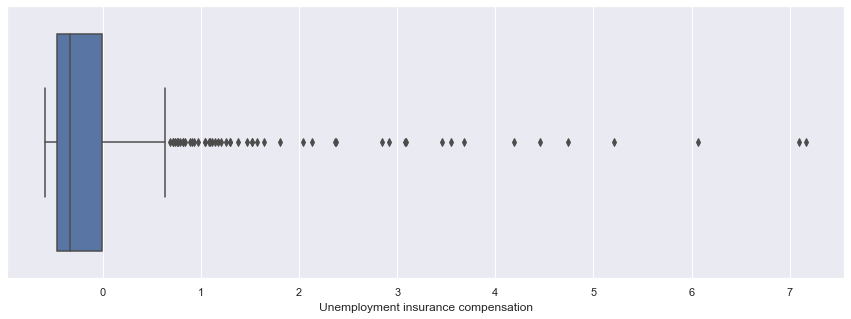

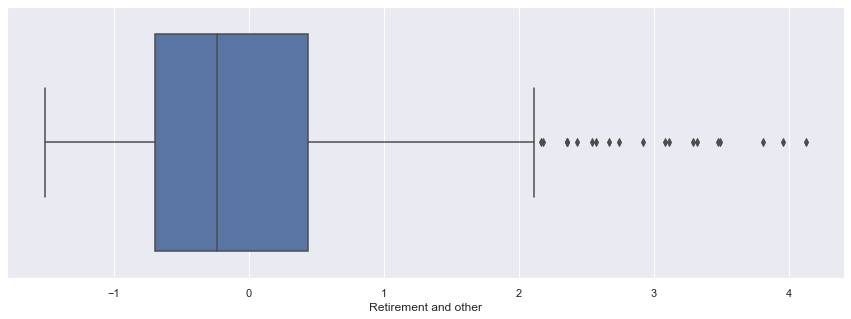

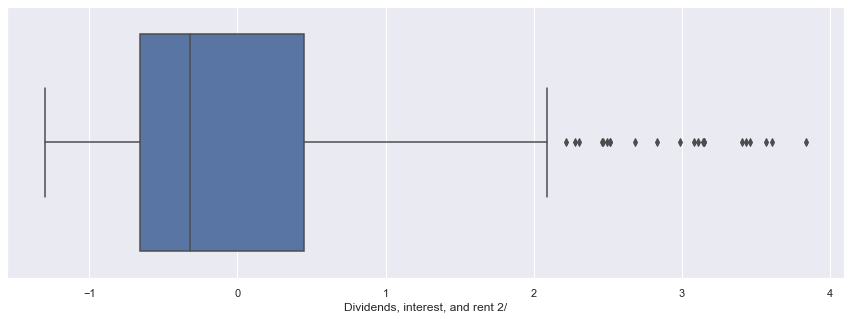

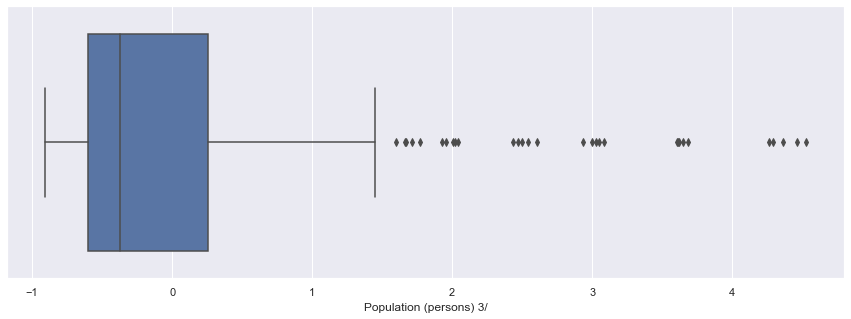

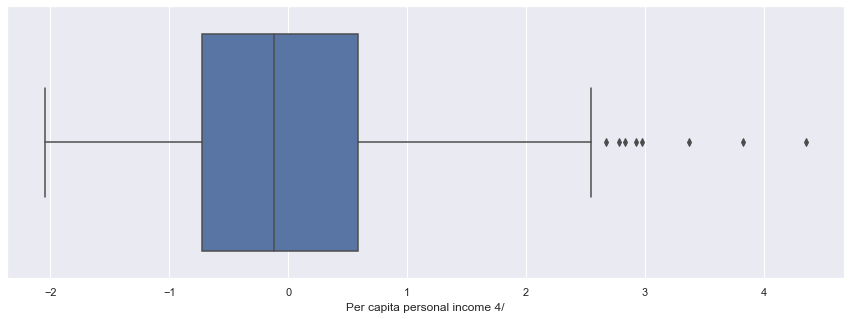

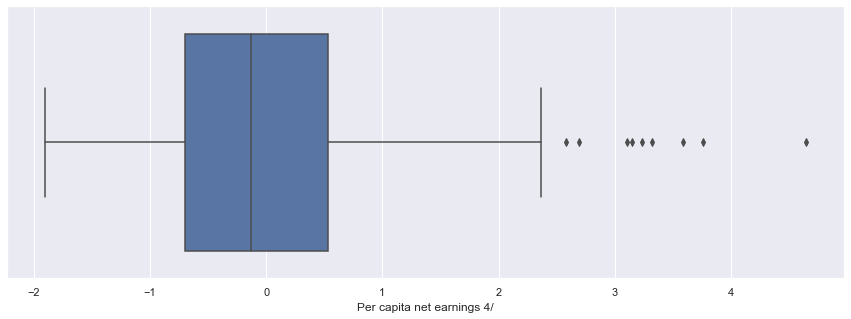

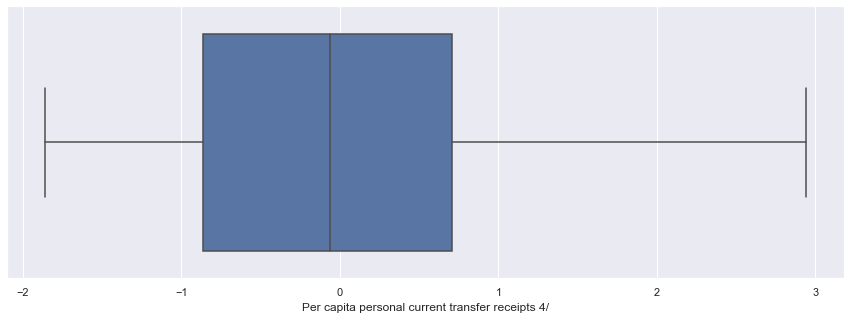

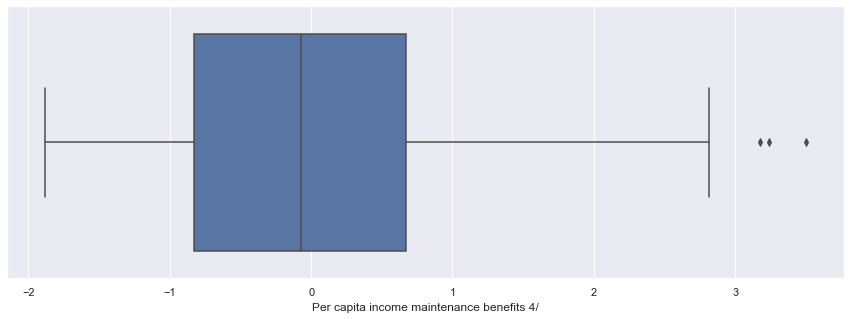

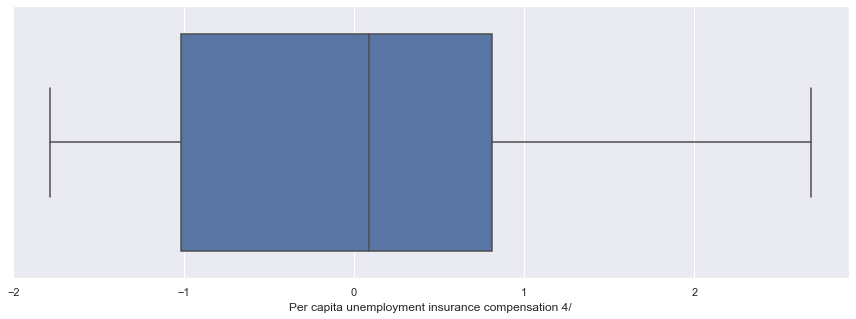

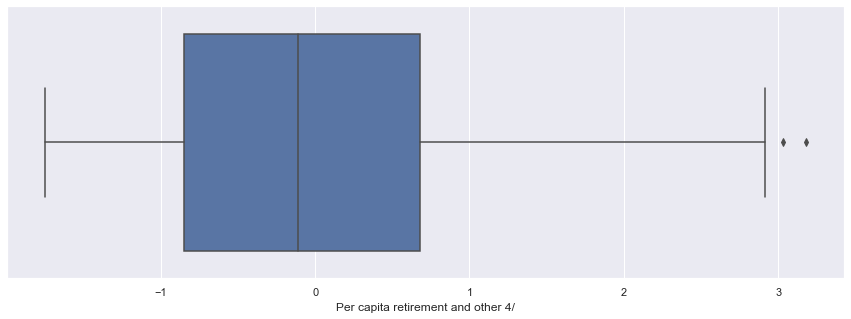

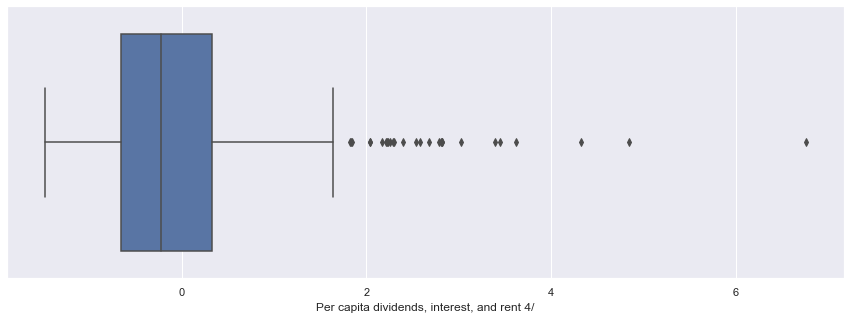

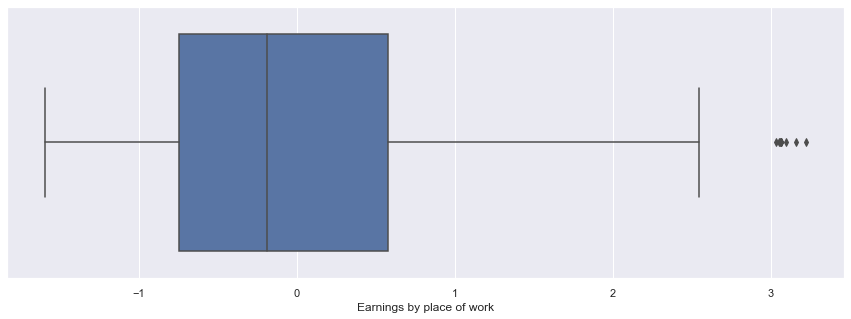

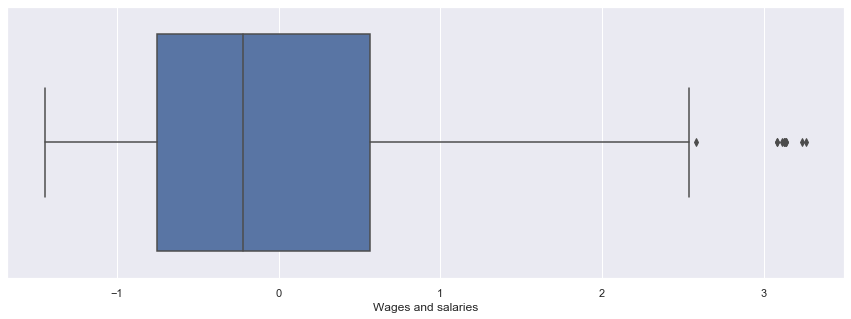

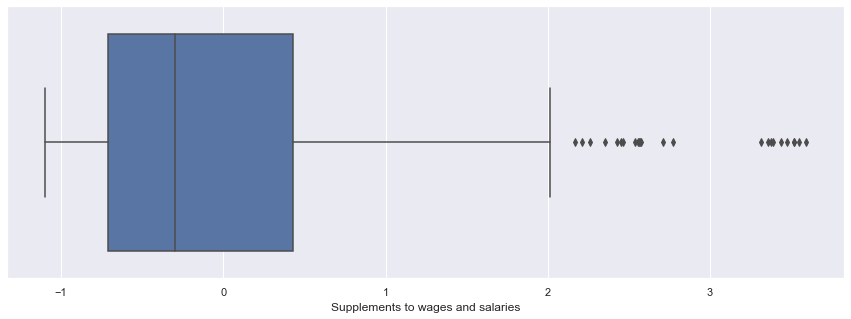

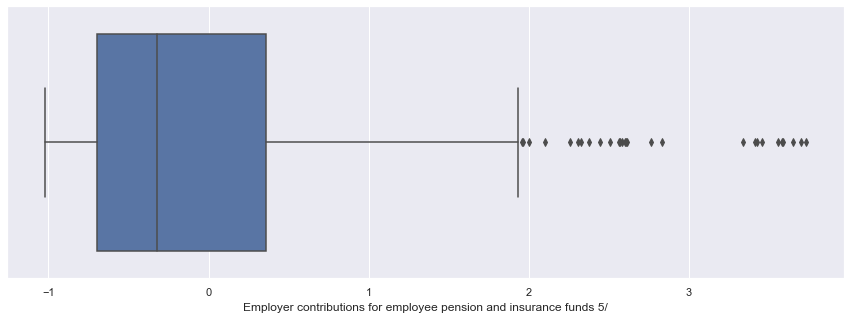

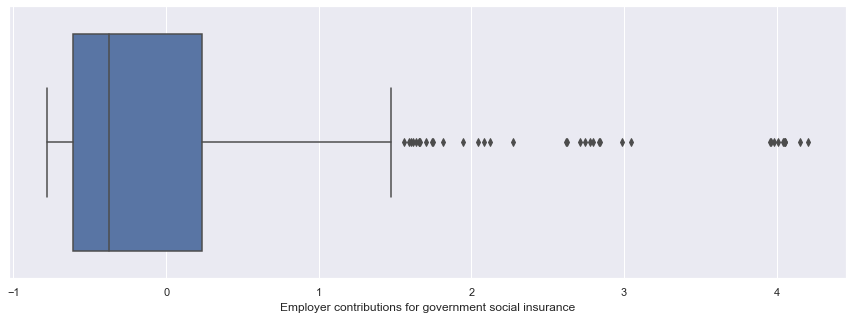

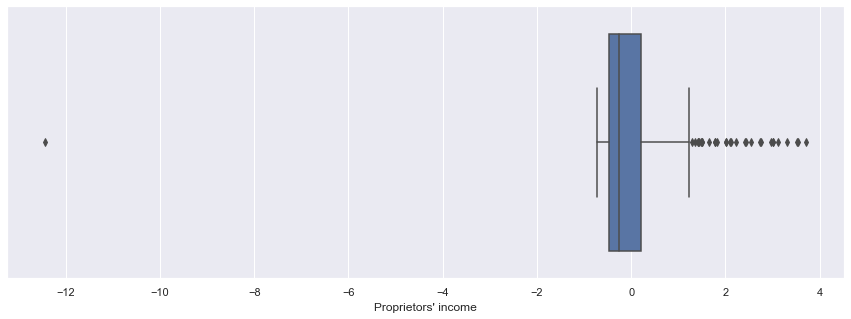

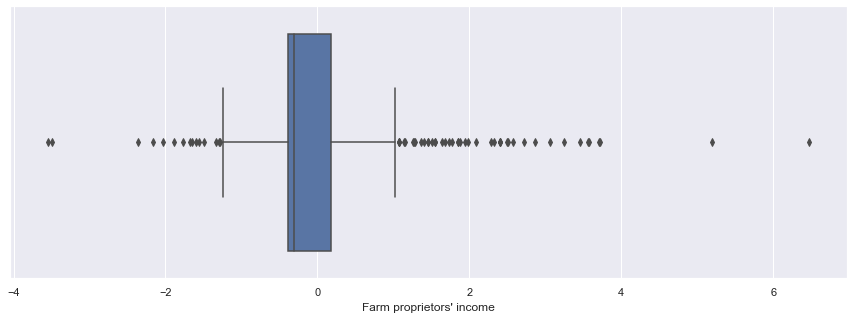

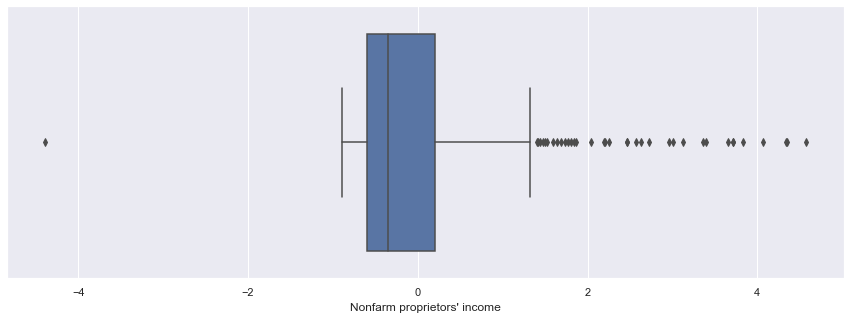

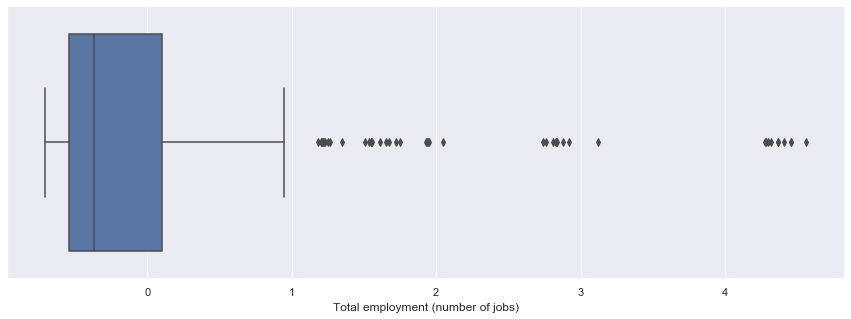

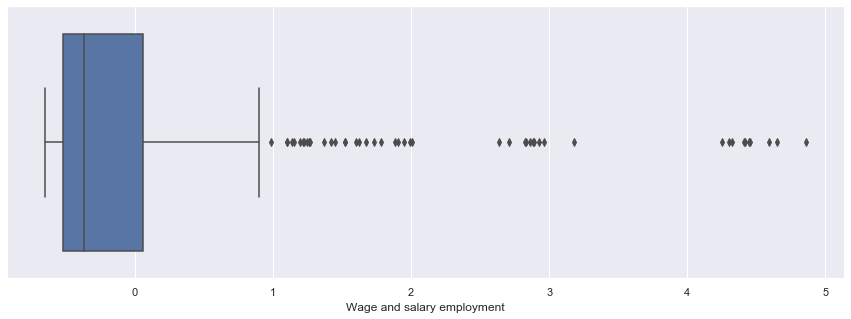

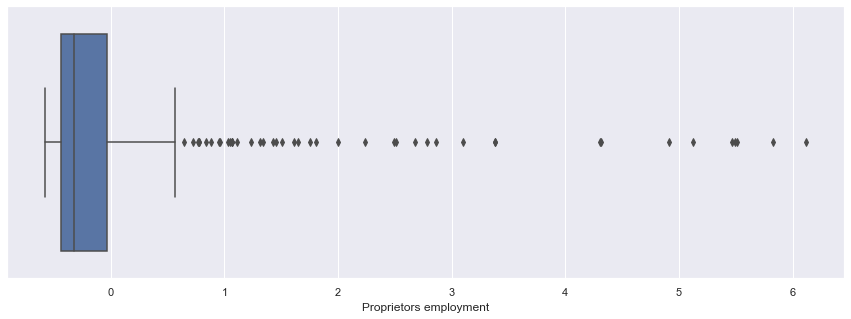

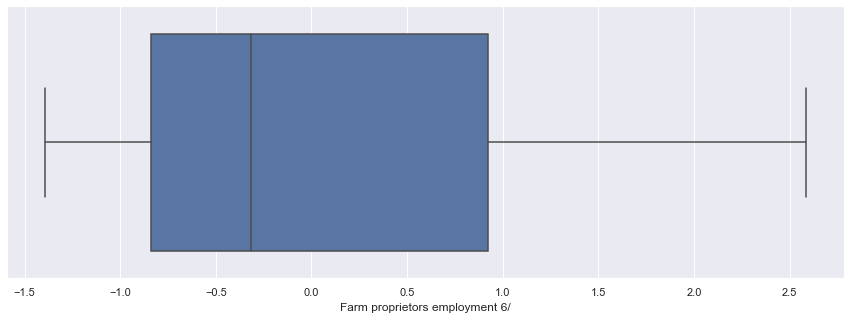

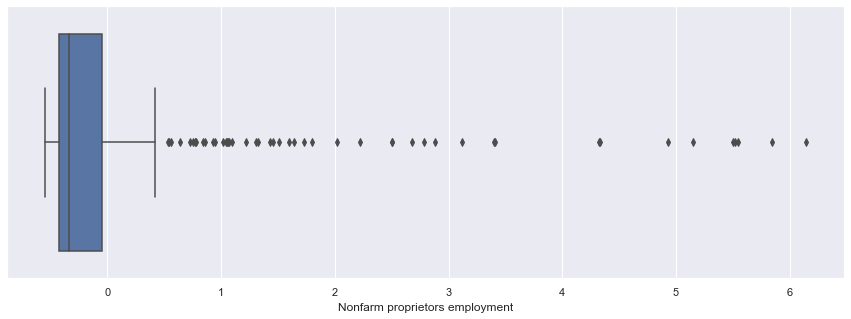

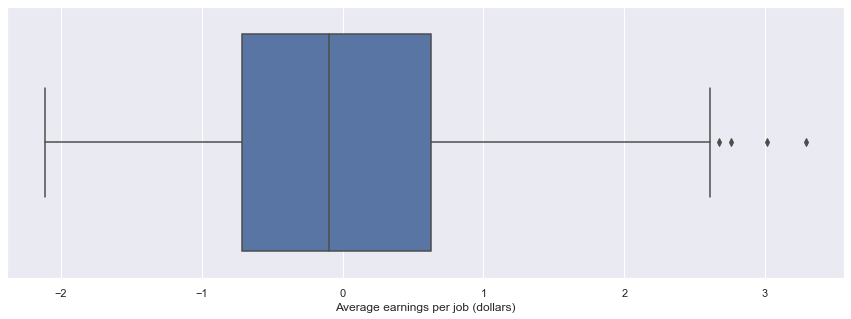

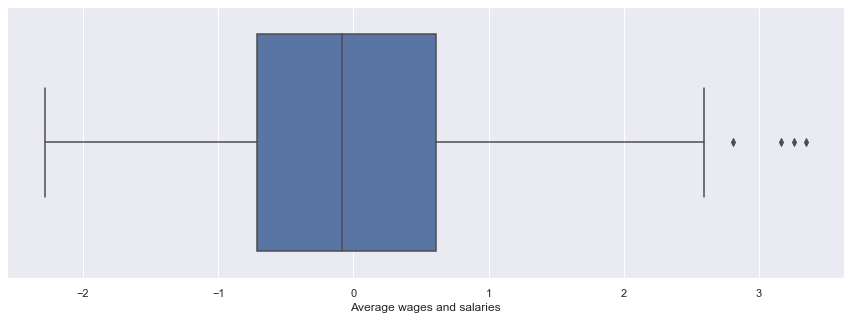

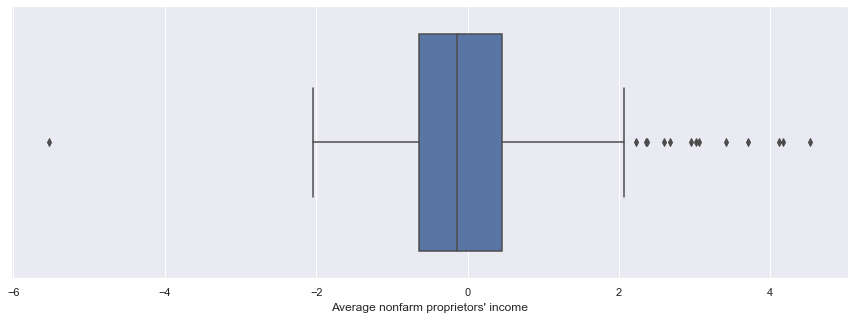

In [6]:
for col in num_cols:
    plt.figure(figsize=(15, 5))
    sns.boxplot(x=df[col])

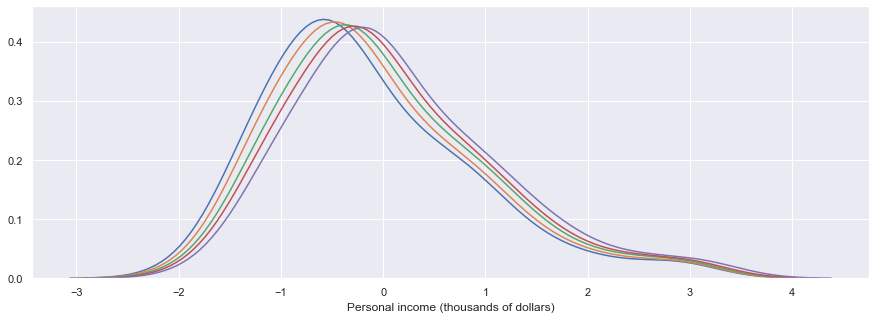

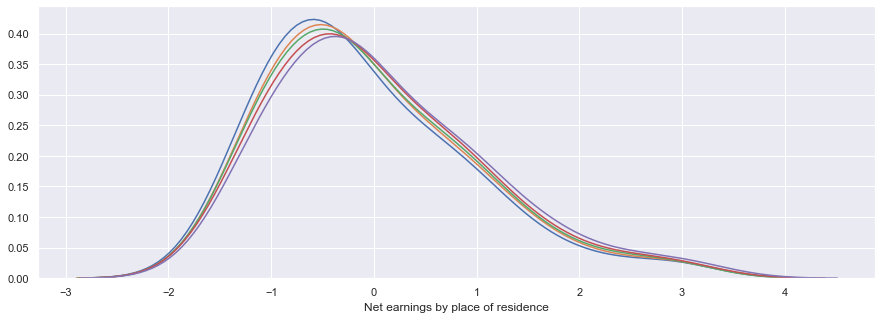

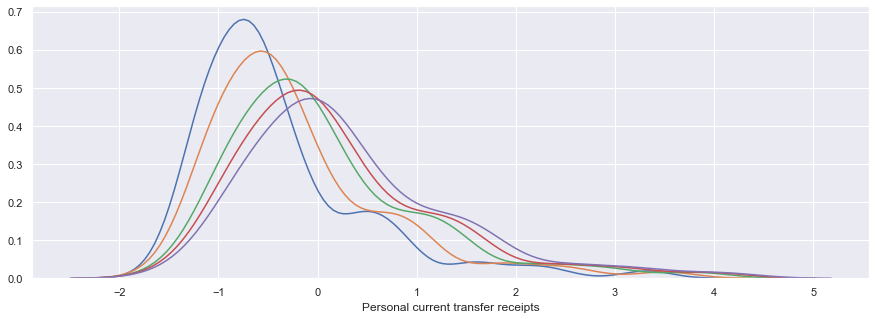

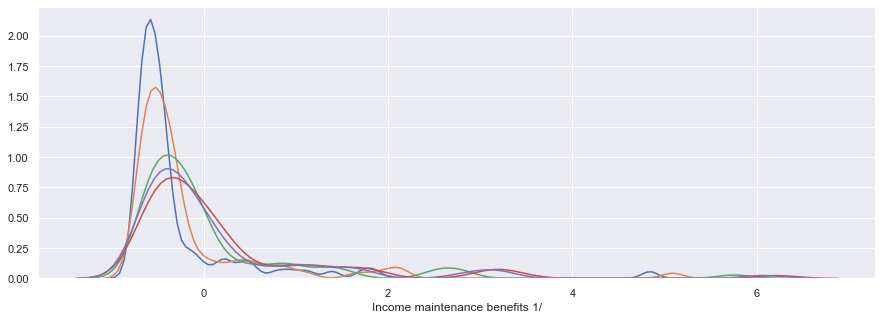

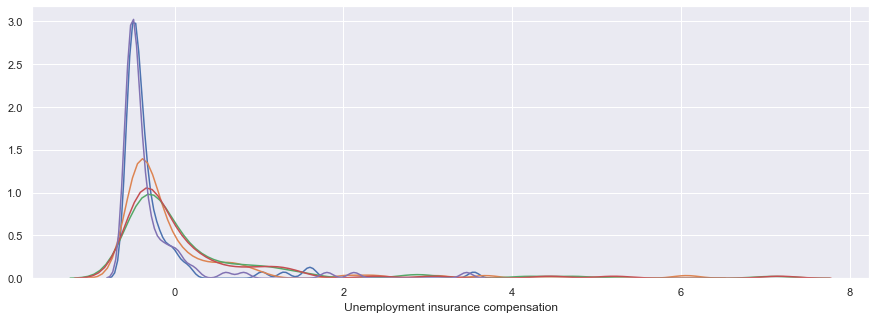

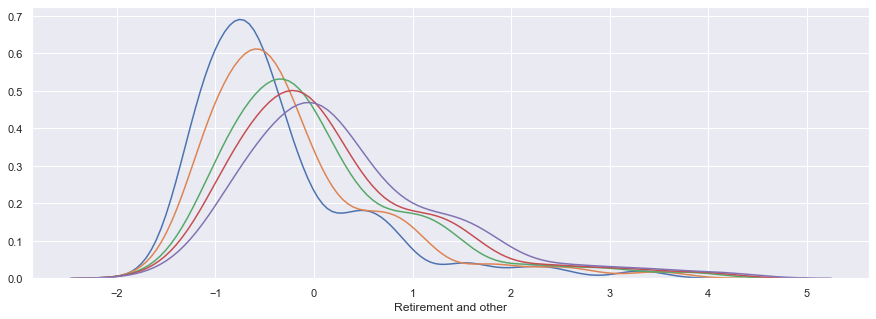

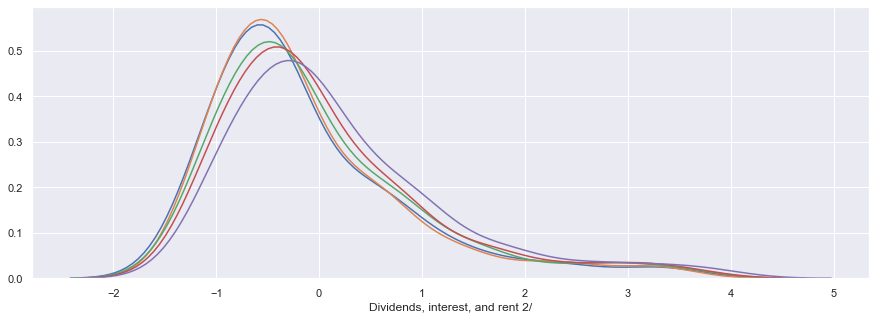

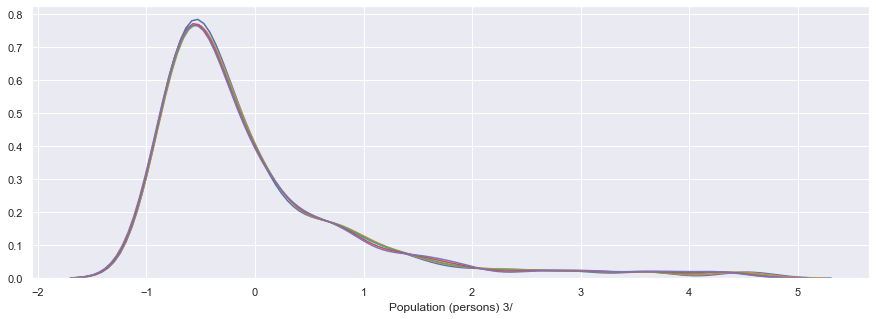

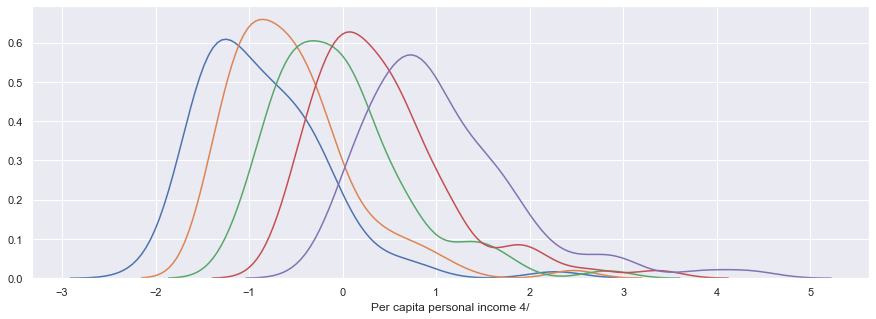

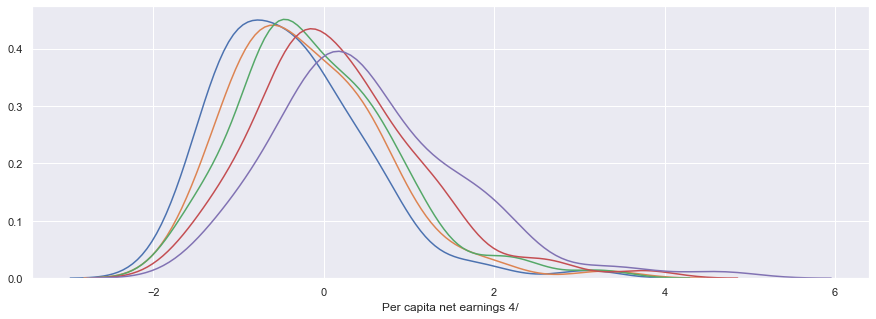

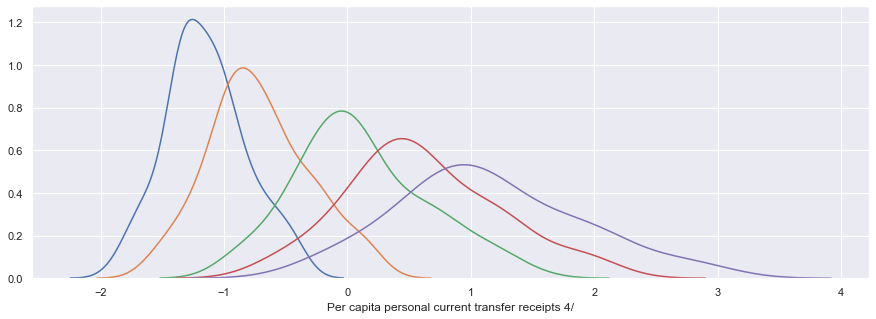

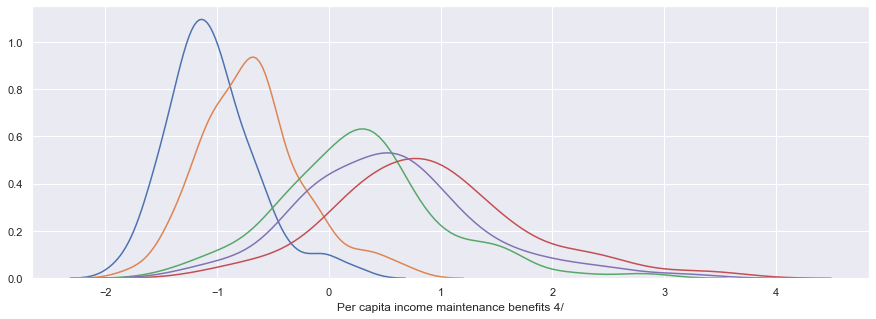

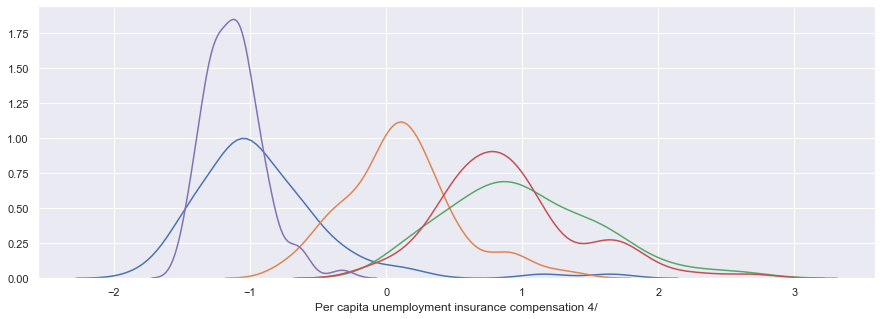

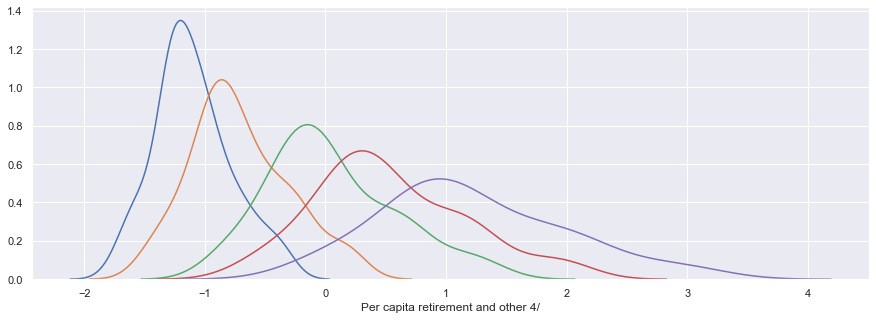

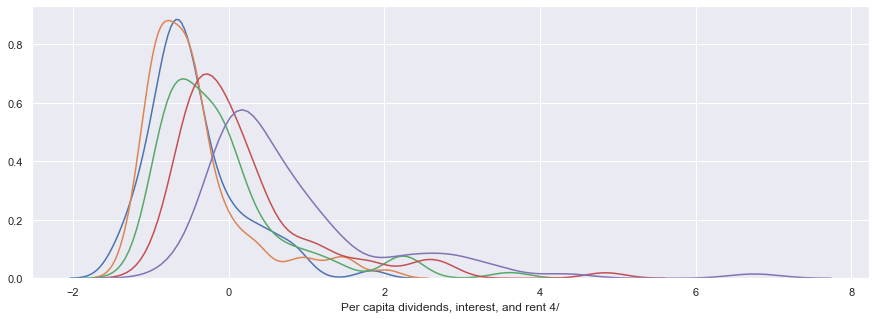

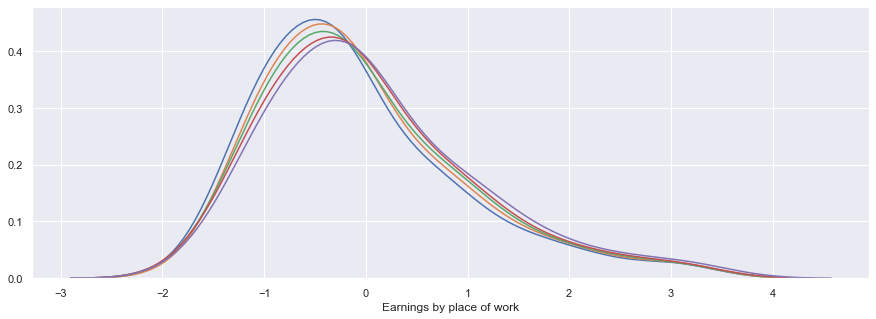

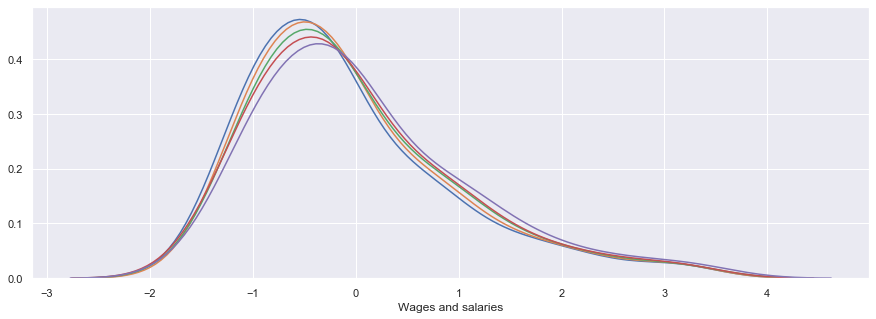

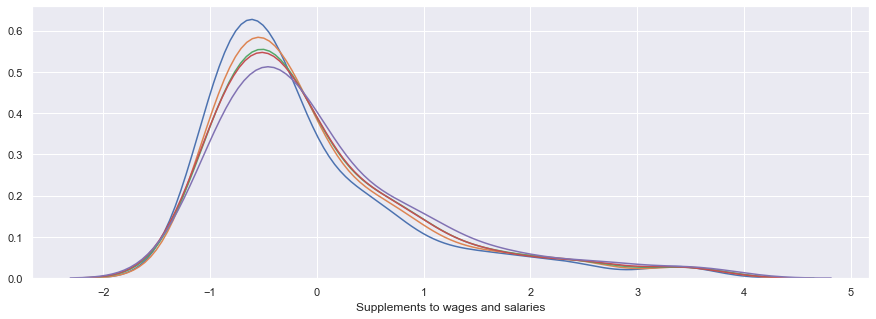

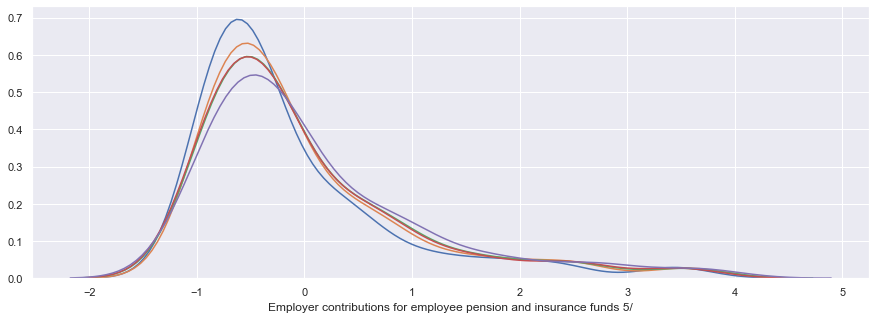

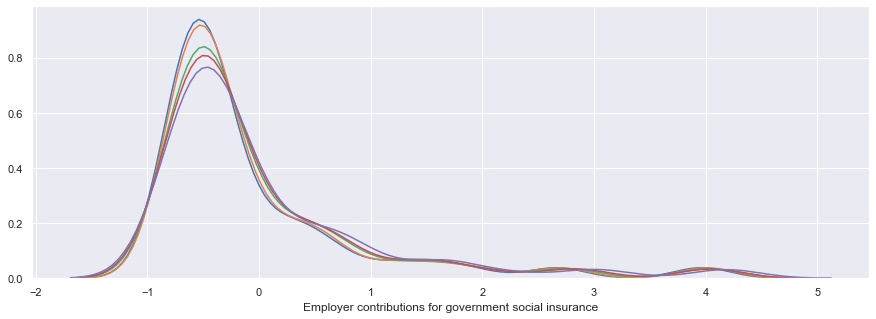

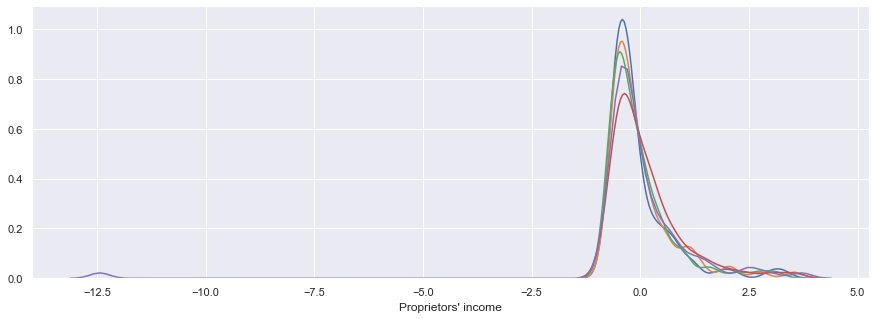

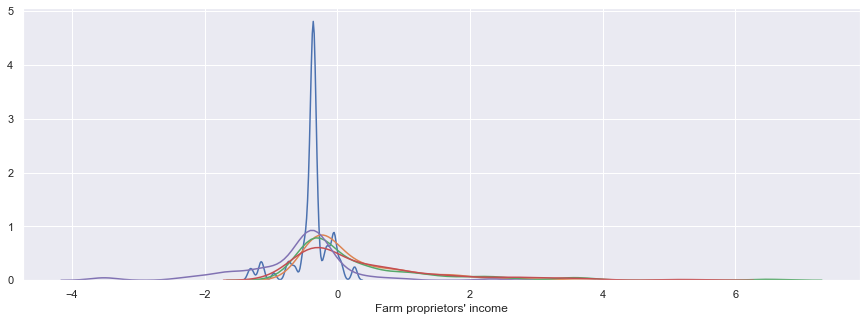

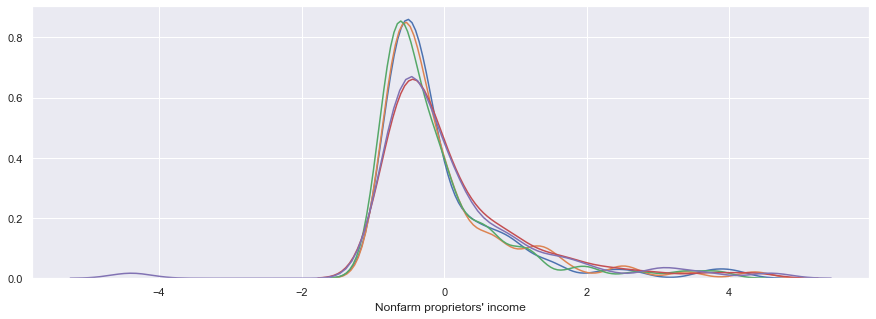

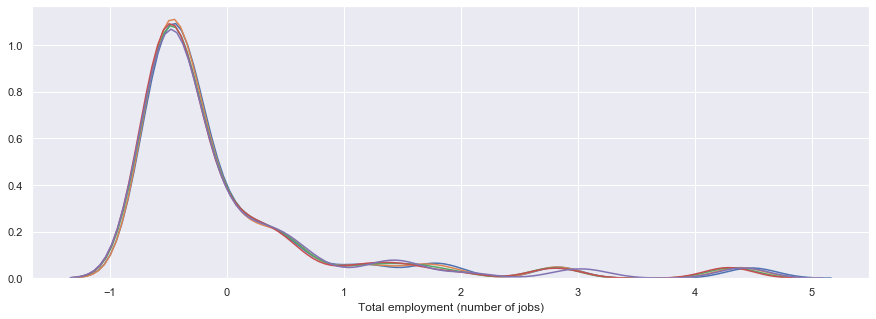

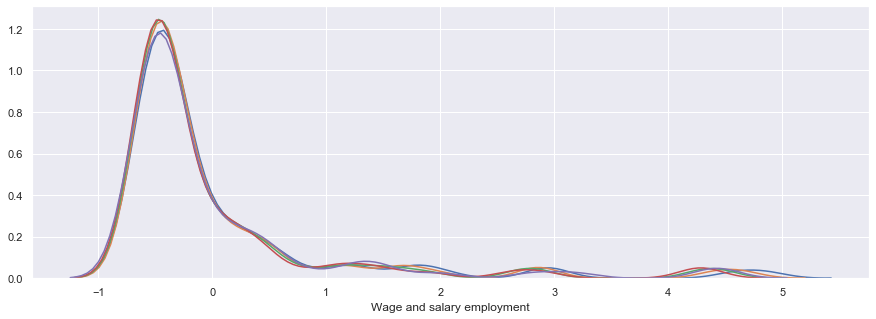

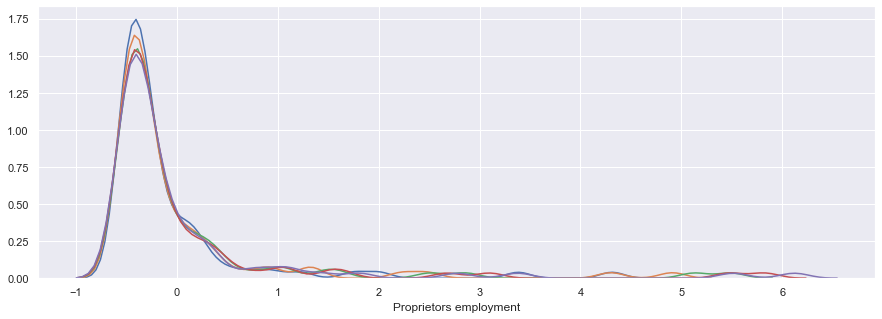

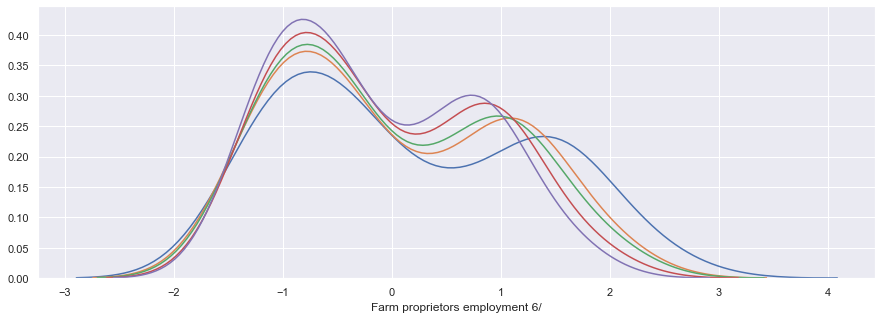

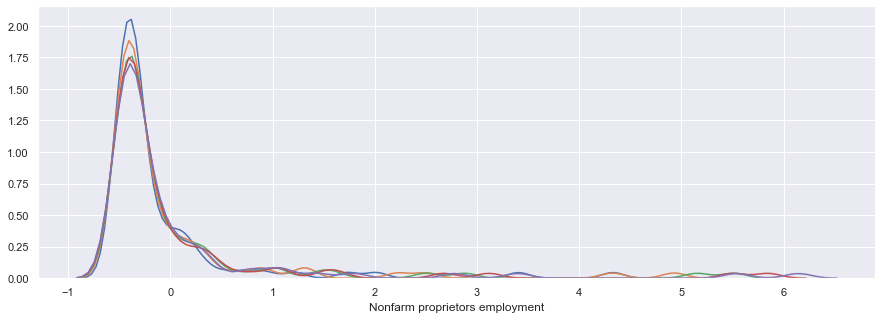

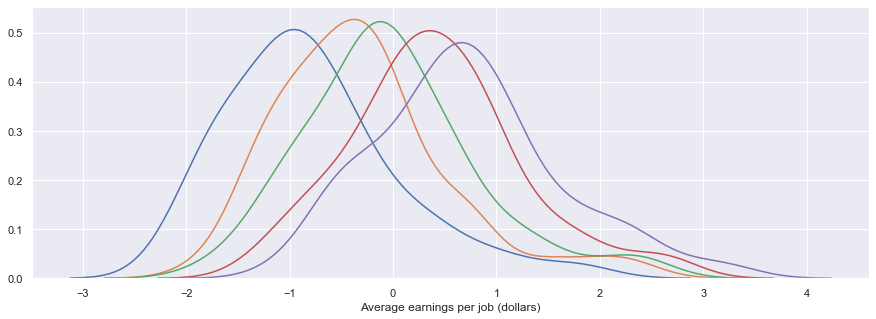

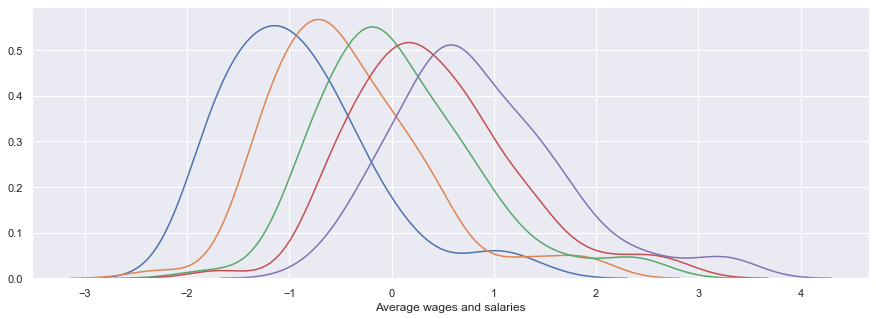

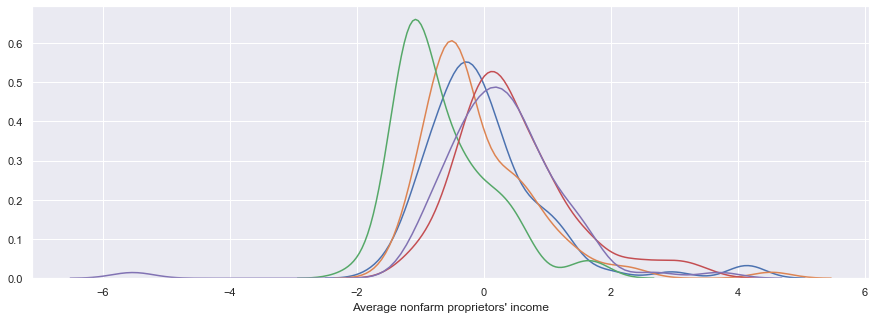

In [7]:
for col in num_cols:
    plt.figure(figsize=(15, 5))
    sns.distplot(df[col][df['year'] == 2000], hist=False)
    sns.distplot(df[col][df['year'] == 2004], hist=False)
    sns.distplot(df[col][df['year'] == 2008], hist=False)
    sns.distplot(df[col][df['year'] == 2012], hist=False)
    sns.distplot(df[col][df['year'] == 2016], hist=False)

In [8]:
cols2use = ['winner',
            'Income maintenance benefits 1/',
            'Unemployment insurance compensation',
            'Retirement and other',
            'Per capita personal income 4/',
            'Per capita net earnings 4/',
            'Per capita personal current transfer receipts 4/',
            'Per capita income maintenance benefits 4/',
            'Per capita unemployment insurance compensation 4/',
            'Per capita retirement and other 4/',
            'Per capita dividends, interest, and rent 4/',
            "Nonfarm proprietors' income",
            'Farm proprietors employment 6/',
            'Average earnings per job (dollars)',
            'Average wages and salaries',
            "Average nonfarm proprietors' income"]

In [9]:
from sklearn.linear_model import LinearRegression
X = df[num_cols].values
y = df['republican'] / df['total_votes']

reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.6063683061216358

In [10]:
data = df[df.columns.difference(info_cols + 
                                ['republican', 'democrat',
                                 'total_votes'])].values
data = df[cols2use].values
row_years = dict(zip(df['year'].unique(),
                     map(lambda x: df[df['year'] == x].index,
                         df['year'].unique())))

data_per_year = list(map(lambda x: data[x, :], list(row_years.values())))

### Mapper
#### SVD Filter

In [11]:
n_components = 1

nintervals = 10
overlap = 0.9

method = 'complete'
metric = 'correlation'
cutoff = FirstGap(0.2)

filtr = SvdFilter(n_components=n_components)

##### 2000

In [12]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[0])
mapper.fit(verbose=0)

In [13]:
col = 'winner'
pos = nx.spring_layout(mapper.complex._graph, seed=0)
size = list(map(lambda x: 12 + x / min(get_node_size(mapper)),
                get_node_size(mapper)))
node_text = []
for node, pct in zip(list(dict(mapper._nodes.items()).values()),
                     get_mean_node(mapper, df=df, col=col)):
        node_text.append(f'# of counties: {len(node._labels)}<br>' +
                         f'Percentage voted for republican: {round(100 * pct, 2)}')
node_color = get_mean_node(mapper, df=df, col=col)

mapper_plotly_plot(mapper, df, pos, size, node_color, node_text, col='winner',
                   colorscale='RdBu', title='Percentage voted for republican')

##### 2004

In [14]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[1])
mapper.fit(verbose=0)

In [15]:
col = 'winner'
pos = nx.spring_layout(mapper.complex._graph, seed=0)
size = list(map(lambda x: 12 + x / min(get_node_size(mapper)),
                get_node_size(mapper)))
node_text = []
for node, pct in zip(list(dict(mapper._nodes.items()).values()),
                     get_mean_node(mapper, df=df, col=col)):
        node_text.append(f'# of counties: {len(node._labels)}<br>' +
                         f'Percentage voted for republican: {round(100 * pct, 2)}')
node_color = get_mean_node(mapper, df=df, col=col)

mapper_plotly_plot(mapper, df, pos, size, node_color, node_text, col='winner',
                   colorscale='RdBu', title='Percentage voted for republican')

##### 2008

In [16]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[2])
mapper.fit(verbose=0)

In [17]:
col = 'winner'
pos = nx.spring_layout(mapper.complex._graph, seed=0)
size = list(map(lambda x: 12 + x / min(get_node_size(mapper)),
                get_node_size(mapper)))
node_text = []
for node, pct in zip(list(dict(mapper._nodes.items()).values()),
                     get_mean_node(mapper, df=df, col=col)):
        node_text.append(f'# of counties: {len(node._labels)}<br>' +
                         f'Percentage voted for republican: {round(100 * pct, 2)}')
node_color = get_mean_node(mapper, df=df, col=col)

mapper_plotly_plot(mapper, df, pos, size, node_color, node_text, col='winner',
                   colorscale='RdBu', title='Percentage voted for republican')

##### 2012

In [18]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[3])
mapper.fit(verbose=0)

In [19]:
col = 'winner'
pos = nx.spring_layout(mapper.complex._graph, seed=0)
size = list(map(lambda x: 12 + x / min(get_node_size(mapper)),
                get_node_size(mapper)))
node_text = []
for node, pct in zip(list(dict(mapper._nodes.items()).values()),
                     get_mean_node(mapper, df=df, col=col)):
        node_text.append(f'# of counties: {len(node._labels)}<br>' +
                         f'Percentage voted for republican: {round(100 * pct, 2)}')
node_color = get_mean_node(mapper, df=df, col=col)

mapper_plotly_plot(mapper, df, pos, size, node_color, node_text, col='winner',
                   colorscale='RdBu', title='Percentage voted for republican')

##### 2016

In [20]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[4])
mapper.fit(verbose=0)

In [21]:
col = 'winner'
pos = nx.spring_layout(mapper.complex._graph, seed=0)
size = list(map(lambda x: 12 + x / min(get_node_size(mapper)),
                get_node_size(mapper)))
node_text = []
for node, pct in zip(list(dict(mapper._nodes.items()).values()),
                     get_mean_node(mapper, df=df, col=col)):
        node_text.append(f'# of counties: {len(node._labels)}<br>' +
                         f'Percentage voted for republican: {round(100 * pct, 2)}')
node_color = get_mean_node(mapper, df=df, col=col)

mapper_plotly_plot(mapper, df, pos, size, node_color, node_text, col='winner',
                   colorscale='RdBu', title='Percentage voted for republican')

<hr style="border: 1px dashed rgb(255,255,255)" color=rgb(0,0,0) size="6">

#### Projection

In [22]:
# ax=2, nintervals=6, overlap=0.5, method='complete', metric='correlation', cutoff=FirstGap(.3)
ax = 11

nintervals = 10
overlap = 0.9

method = 'complete'
metric = 'correlation'
cutoff = FirstGap(.3)

filtr = Projection(ax=ax)

In [23]:
df['perc'] = df['republican'] / df['total_votes']
df.head()

year     state  county   fips  pres  republican  democrat  total_votes  \
0  2000  Michigan  Alcona  26001     1      3152.0    2696.0       5997.0   
1  2004  Michigan  Alcona  26001     1      3592.0    2871.0       6531.0   
2  2008  Michigan  Alcona  26001     0      3404.0    2896.0       6420.0   
3  2012  Michigan  Alcona  26001     0      3571.0    2472.0       6104.0   
4  2016  Michigan  Alcona  26001     1      4201.0    1732.0       6198.0   

   winner  Personal income (thousands of dollars)  ...  \
0       1                               -1.212484  ...   
1       1                               -1.185326  ...   
2       1                               -1.111308  ...   
3       1                               -1.056686  ...   
4       1                               -0.991396  ...   

   Nonfarm proprietors' income  Total employment (number of jobs)  \
0                    -0.653711                          -0.640199   
1                    -0.741615                          -0.649803   
2                    -0.790061                          -0.654468   
3                    -0.723345                          -0.657243   
4                    -0.754733                          -0.653836   

   Wage and salary employment  Proprietors employment  \
0                   -0.612568               -0.487563   
1                   -0.614200               -0.510492   
2                   -0.618477               -0.512675   
3                   -0.621482               -0.512790   
4                   -0.617088               -0.514456   

   Farm proprietors employment 6/  Nonfarm proprietors employment  \
0                       -0.792590                       -0.471796   
1                       -0.816836                       -0.494214   
2                       -0.811987                       -0.496518   
3                       -0.892013                       -0.494733   
4                       -0.916268                       -0.495827   

   Average earnings per job (dollars)  Average wages and salaries  \
0                           -1.984036                   -1.837113   
1                           -1.575581                   -1.345071   
2                           -1.422656                   -0.809221   
3                           -0.950050                   -0.349702   
4                           -0.817198                   -0.040434   

   Average nonfarm proprietors' income      perc  
0                            -0.072882  0.525596  
1                            -0.439174  0.549992  
2                            -1.105251  0.530218  
3                            -0.138522  0.585026  
4                            -0.578045  0.677799  

[5 rows x 41 columns]

##### 2000

In [24]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[0])
mapper.fit(verbose=0)

In [25]:
col = 'winner'
pos = nx.spring_layout(mapper.complex._graph, seed=0)
size = list(map(lambda x: 12 + x / min(get_node_size(mapper)),
                get_node_size(mapper)))
node_text = []
for node, pct in zip(list(dict(mapper._nodes.items()).values()),
                     get_mean_node(mapper, df=df, col=col)):
        node_text.append(f'# of counties: {len(node._labels)}<br>' +
                         f'Percentage voted for republican: {round(100 * pct, 2)}')
node_color = get_mean_node(mapper, df=df, col=col)

mapper_plotly_plot(mapper, df, pos, size, node_color, node_text, col='winner',
                   colorscale='RdBu', title='Percentage voted for republican')

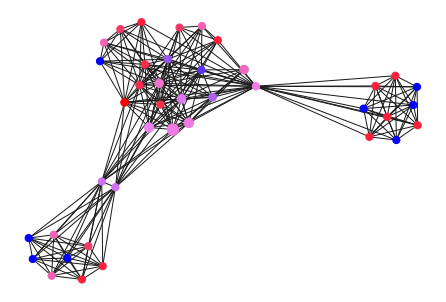

In [26]:
mapper_nx_plot(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='Per capita net earnings 4/'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2004

In [27]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[1])
mapper.fit(verbose=0)

In [28]:
col = 'winner'
pos = nx.spring_layout(mapper.complex._graph, seed=0)
size = list(map(lambda x: 12 + x / min(get_node_size(mapper)),
                get_node_size(mapper)))
node_text = []
for node, pct in zip(list(dict(mapper._nodes.items()).values()),
                     get_mean_node(mapper, df=df, col=col)):
        node_text.append(f'# of counties: {len(node._labels)}<br>' +
                         f'Percentage voted for republican: {round(100 * pct, 2)}')
node_color = get_mean_node(mapper, df=df, col=col)

mapper_plotly_plot(mapper, df, pos, size, node_color, node_text, col='winner',
                   colorscale='RdBu', title='Percentage voted for republican')

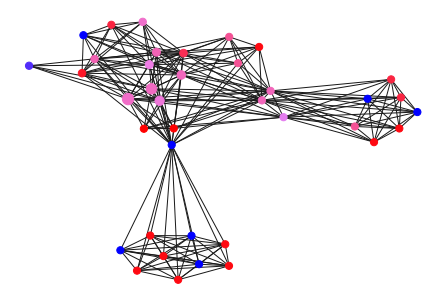

In [29]:
mapper_nx_plot(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='Per capita net earnings 4/'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2008

In [30]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[2])
mapper.fit(verbose=0)

In [31]:
col = 'winner'
pos = nx.spring_layout(mapper.complex._graph, seed=0)
size = list(map(lambda x: 12 + x / min(get_node_size(mapper)),
                get_node_size(mapper)))
node_text = []
for node, pct in zip(list(dict(mapper._nodes.items()).values()),
                     get_mean_node(mapper, df=df, col=col)):
        node_text.append(f'# of counties: {len(node._labels)}<br>' +
                         f'Percentage voted for republican: {round(100 * pct, 2)}')
node_color = get_mean_node(mapper, df=df, col=col)

mapper_plotly_plot(mapper, df, pos, size, node_color, node_text, col='winner',
                   colorscale='RdBu', title='Percentage voted for republican')

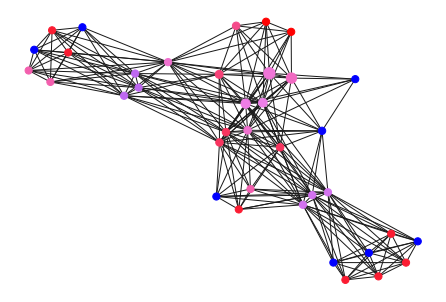

In [32]:
mapper_nx_plot(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='Per capita net earnings 4/'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2012

In [33]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[3])
mapper.fit(verbose=0)

In [34]:
col = 'winner'
pos = nx.spring_layout(mapper.complex._graph, seed=0)
size = list(map(lambda x: 12 + x / min(get_node_size(mapper)),
                get_node_size(mapper)))
node_text = []
for node, pct in zip(list(dict(mapper._nodes.items()).values()),
                     get_mean_node(mapper, df=df, col=col)):
        node_text.append(f'# of counties: {len(node._labels)}<br>' +
                         f'Percentage voted for republican: {round(100 * pct, 2)}')
node_color = get_mean_node(mapper, df=df, col=col)

mapper_plotly_plot(mapper, df, pos, size, node_color, node_text, col='winner',
                   colorscale='RdBu', title='Percentage voted for republican')

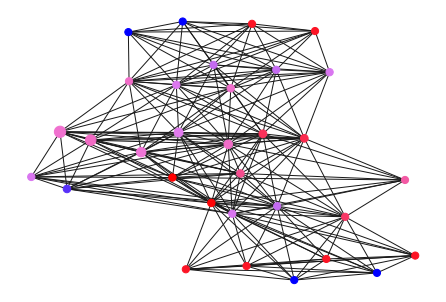

In [35]:
mapper_nx_plot(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='Per capita net earnings 4/'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2016

In [36]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[4])
mapper.fit(verbose=0)

In [37]:
col = 'winner'
pos = nx.spring_layout(mapper.complex._graph, seed=0)
size = list(map(lambda x: 12 + x / min(get_node_size(mapper)),
                get_node_size(mapper)))
node_text = []
for node, pct in zip(list(dict(mapper._nodes.items()).values()),
                     get_mean_node(mapper, df=df, col=col)):
        node_text.append(f'# of counties: {len(node._labels)}<br>' +
                         f'Percentage voted for republican: {round(100 * pct, 2)}')
node_color = get_mean_node(mapper, df=df, col=col)

mapper_plotly_plot(mapper, df, pos, size, node_color, node_text, col='winner',
                   colorscale='RdBu', title='Percentage voted for republican')

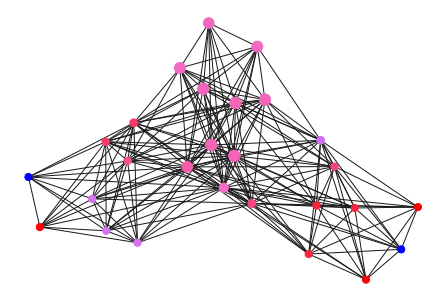

In [38]:
mapper_nx_plot(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='Per capita net earnings 4/'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))